In [2]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
sns.set_style("darkgrid")

### Make smoothed version of spline

In [3]:
spline_df = pd.read_csv("ssa_historical_itn.csv")

In [4]:
def fit_lowess_spline(x, y, frac=0.67, return_error=False, percentile_top=80, percentile_bottom=20):
    # From https://james-brennan.github.io/posts/lowess_conf/
    from statsmodels.nonparametric.smoothers_lowess import lowess as sm_lowess

    def smooth(x, y, xgrid, frac=0.67):
        samples = np.random.choice(len(x), 50, replace=True)
        y_s = y[samples]
        x_s = x[samples]
        y_sm = sm_lowess(y_s, x_s, frac=frac, it=5,
                         return_sorted=False)
        # regularly sample it onto the grid
        y_grid = scipy.interpolate.interp1d(x_s, y_sm,
                                            fill_value='extrapolate')(xgrid)
        return y_grid

    if not return_error:
        sm_x, sm_y = sm_lowess(y, x, frac=frac, return_sorted=True).T
        return sm_x, sm_y
    elif return_error:
        xgrid = np.linspace(x.min(), x.max())
        K = 100
        smooths = np.stack([smooth(x, y, xgrid, frac=frac) for k in range(K)]).T

        mean = np.nanmean(smooths, axis=1)
        #         median = np.nanmedian(smooths, axis=1)
        q_top = np.nanpercentile(smooths, percentile_top, axis=1)
        q_bot = np.nanpercentile(smooths, percentile_bottom, axis=1)

        return xgrid, mean, q_bot, q_top


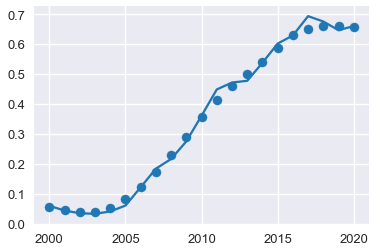

In [7]:
x = spline_df["year"]
y = spline_df["cov_all"]
xs,ys = fit_lowess_spline(x,y,frac=0.3)

plt.scatter(xs,ys)
plt.plot(x,y)

In [8]:
spline_df["cov_smoothed"] = ys

In [9]:
spline_df.to_csv("ssa_historical_itn.csv", index=False)

### Now apply smoothed spline to healthseeking.  

Easiest is to assume same hs rate as ITN coverage.  This of course doesn't make much sense in terms of units, but the numbers seem to work out about the same, if we want to end on ~65% HS

In [14]:
hs_df = spline_df.copy(deep=True).rename(columns={"cov_smoothed": "cov_newclin_youth"})[["year", "cov_newclin_youth"]]

In [15]:
hs_df

,year,cov_newclin_youth
0,2000,0.054991
1,2001,0.046724
2,2002,0.039236
3,2003,0.038605
4,2004,0.051682
5,2005,0.081496
6,2006,0.123449
7,2007,0.172832
8,2008,0.227889
9,2009,0.288839


In [16]:
hs_df.to_csv("ssa_historical_hs.csv", index=False)